In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import json
import os
from os import listdir
from os.path import isfile, join
from pycocotools import mask as _mask
import torch

from h_detectron2 import *
from h_cutler import *
from h_json import *

p = 6
plt.rcParams['figure.figsize'] = [1.5*p,p]

Once CutLER is done with his training, the weights are used to evaluate more complex datasets:

* jerry_2500GT: synthetic data (easier) but density is not controlled as well as occlusions.
* jerry_real: real data (no control)


## jerry_2500GT

#### Path to datasets, annotations

In [2]:
# path to data/annotations in "system" format
syspath="/home/dkhatanassia/detectron2_dataset"

#*************************************** datasets *****************************************
dataset_train = 'jerry_sp10'
dataset_test = 'jerry_2500GT'
DPI = 50
#******************************************************************************************

# root
root_train = join(syspath,dataset_train)
root_test = join(syspath,dataset_test)

# path to images{train, test}
imgs_train = join(root_train,'imgs')
imgs_test = join(root_test,'imgs')

# path to json{train, test}
json_name_GT = f'GT_{dataset_test}.json'
json_name_GT_tr = f'tr_GT_{dataset_train}.json'
json_name_GT_te = f'te_GT_{dataset_test}.json'
json_name_mc = f'mc_{dataset_test}.json'
json_name_mc_tr = f'tr_mc_{dataset_train}.json'
json_name_mc_te = f'te_mc_{dataset_test}.json'

json_path_GT = join(root_test,'annotations',json_name_GT)
json_path_GT_tr = join(root_train,'annotations',json_name_GT_tr)
json_path_GT_te = join(root_test,'annotations',json_name_GT_te)
json_path_mc = join(root_test,'annotations',json_name_mc)
json_path_mc_tr = join(root_train,'annotations',json_name_mc_tr)
json_path_mc_te = join(root_test,'annotations',json_name_mc_te)

# builtin datasets location
%cd ~/CutLER/cutler
os.environ['DETECTRON2_DATASETS']='/home/dkhatanassia/CutLER/cutler/datasets'
print(os.getenv('DETECTRON2_DATASETS'))

/home/dkhatanassia/CutLER/cutler
/home/dkhatanassia/CutLER/cutler/datasets


#### Register datasets to detectron2

In [3]:
# register datasets
d2name = [
    json_name_GT,
    json_name_GT_tr,
    json_name_GT_te,
    json_name_mc,
    json_name_mc_tr,
    json_name_mc_te]

d2imgs = [
    imgs_test,
    imgs_train,
    imgs_test,
    imgs_test,
    imgs_train,
    imgs_test]

d2json = [
    json_path_GT,
    json_path_GT_tr,
    json_path_GT_te,
    json_path_mc,
    json_path_mc_tr,
    json_path_mc_te]

for key in range(len(d2name)):
    if not os.path.exists(d2json[key]): continue
    registerCatalog(d2name[key],d2json[key],d2imgs[key])

registered: GT_jerry_2500GT.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_2500GT/annotations/GT_jerry_2500GT.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_2500GT/imgs

registered: tr_GT_jerry_sp10.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_sp10/annotations/tr_GT_jerry_sp10.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_sp10/imgs

registered: te_GT_jerry_2500GT.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_2500GT/annotations/te_GT_jerry_2500GT.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_2500GT/imgs

registered: mc_jerry_2500GT.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_2500GT/annotations/mc_jerry_2500GT.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_2500GT/imgs

registered: tr_mc_jerry_sp10.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_sp10/annotations/tr_mc_jerry_sp10.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_sp10/imgs

registered: te_mc_

#### Path to weights, outputs, ...

In [4]:
# current round
rnd = 'eval'

# path to output for current round
p2o = join(root_test,f'rd{rnd}')
if not os.path.exists(p2o):
    os.makedirs(p2o)
    print(f'created: {p2o}\n')
    
p2cfg = 'model_zoo/configs/CutLER-ImageNet/sp10_cascade_mask_rcnn_R_50_FPN.yaml'
p2w = '/home/dkhatanassia/CutLER/cutler/weights/jerry_sp10.pth'

#**** ANNOTATIONS *****
# path to new predictions
p2np =join(p2o,'inference/coco_instances_results.json')
# path to previous json
p2pj_tr = json_path_mc_tr
p2pj_te = json_path_mc_te

dict_path = {
    'config':p2cfg,
    'output':p2o,
    'new predictions':p2np,
    'prev json_tr':p2pj_tr,
    'prev json_te': p2pj_te}

print(f'ROUND: {rnd}')
[print(f'path to {d}: {dict_path[d].replace(root_train,".")}') for d in dict_path]


ROUND: eval
path to config: model_zoo/configs/CutLER-ImageNet/sp10_cascade_mask_rcnn_R_50_FPN.yaml
path to output: /home/dkhatanassia/detectron2_dataset/jerry_2500GT/rdeval
path to new predictions: /home/dkhatanassia/detectron2_dataset/jerry_2500GT/rdeval/inference/coco_instances_results.json
path to prev json_tr: ./annotations/tr_mc_jerry_sp10.json
path to prev json_te: /home/dkhatanassia/detectron2_dataset/jerry_2500GT/annotations/te_mc_jerry_2500GT.json


[None, None, None, None, None]

#### Test DPI and th

In [5]:
p2dpith = join(p2o,'DPI_th')

DPIs = [1,5,10,50]
ths = [0.01] + list(np.arange(0.5,1,0.05).round(2)) + [0.99]

##### generate jsons

In [ ]:
for dpi in DPIs:
    %cd ~/CutLER/cutler
    %run train_net.py --num-gpus 1 \
    --config-file model_zoo/configs/CutLER-ImageNet/sp10_cascade_mask_rcnn_R_50_FPN.yaml \
    --test-dataset '{json_name_mc_te}'\
    --eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}'\
    MODEL.WEIGHTS '{p2w}' \
    OUTPUT_DIR '{p2dpith}'
        
    for tmp_th in ths:
        tmp_pred = join(p2dpith,'inference','coco_instances_results.json')
        tmp_rnd_name = f'te_{dataset_test}_rd{rnd}_DPI{dpi}_th{tmp_th}.json'
        tmp_new = join(p2dpith,tmp_rnd_name)
    
        %cd ~/CutLER/cutler/tools
        %run get_self_training_ann.py \
        --new-pred '{tmp_pred}' \
        --prev-ann '{p2pj_te}'  \
        --save-path '{tmp_new}' \
        --threshold '{tmp_th}'

4828


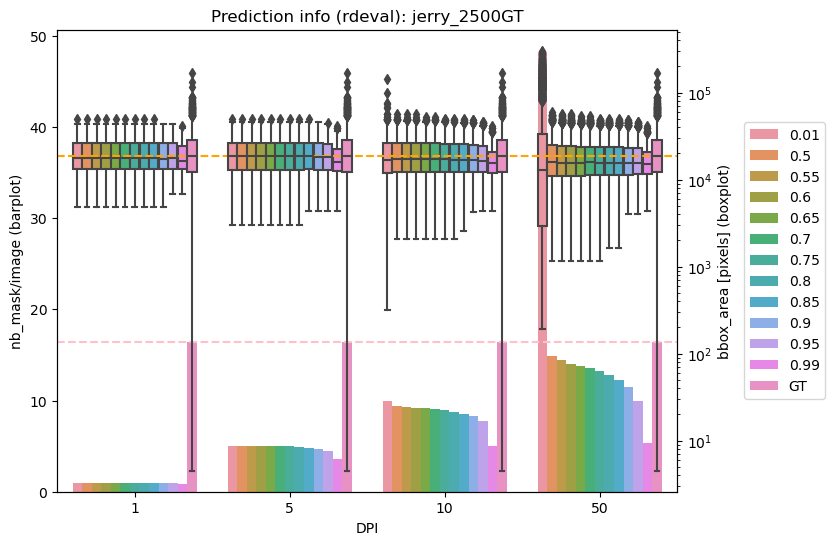

In [9]:
plotDPIthInfo(p2dpith,rnd,DPIs,ths,dataset_test,json_path_GT_te)

#### Generate new predictions based on results, threshold them

In [18]:
dpi = 5
th = 0.3

rnd_name_te = f'te_{dataset_test}_rd{rnd}_DPI{dpi}_th{th}.json'
p2nj_te = join(p2o,rnd_name_te)

In [19]:
# test - generate using dpi
%cd ~/CutLER/cutler
%run train_net.py --num-gpus 1 \
--config-file model_zoo/configs/CutLER-ImageNet/sp10_cascade_mask_rcnn_R_50_FPN.yaml \
--test-dataset '{json_name_GT_te}' \
--eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}' \
MODEL.WEIGHTS '{p2w}' \
OUTPUT_DIR '{p2o}'
# test - threshold
%cd ~/CutLER/cutler/tools
%run get_self_training_ann.py \
--new-pred '{p2np}' \
--prev-ann '{p2pj_te}'  \
--save-path '{p2nj_te}' \
--threshold '{th}'

/home/dkhatanassia/CutLER/cutler
Command Line Args: Namespace(config_file='model_zoo/configs/CutLER-ImageNet/sp10_cascade_mask_rcnn_R_50_FPN.yaml', resume=False, eval_only=True, num_gpus=1, num_machines=1, machine_rank=0, test_dataset='te_GT_jerry_2500GT.json', train_dataset='', no_segm=False, dist_url='tcp://127.0.0.1:50153', opts=['TEST.DETECTIONS_PER_IMAGE', '5', 'MODEL.WEIGHTS', '/home/dkhatanassia/CutLER/cutler/weights/jerry_sp10.pth', 'OUTPUT_DIR', '/home/dkhatanassia/detectron2_dataset/jerry_2500GT/rdeval'])
[06/13 11:14:17 detectron2]: Rank of current process: 0. World size: 1
[06/13 11:14:17 detectron2]: Rank of current process: 0. World size: 1
[06/13 11:14:17 detectron2]: Environment info:
-------------------------------  ----------------------------------------------------------------------------------------------
sys.platform                     linux
Python                           3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:57:19) [GCC 11.3.0]
numpy       

0it [00:00, ?it/s]

Done: 100 images; 500 anns.


In [20]:
with open(join(p2o,rnd_name_te), 'r') as f:
    lala= json.load(f)
for d in lala['images']:
    d['id'] = int(d['file_name'].split('.')[0])
with open(join(p2o,rnd_name_te), 'w') as f:
    json.dump(lala, f)
    

df_bbox = init_df(p2o)
df_segm = init_df(p2o)
get_results(p2o, df_bbox, df_segm, 'eval')
df_bbox.to_csv(join(p2o,'bbox.csv'), index=False)
df_segm.to_csv(join(p2o,'segm.csv'), index=False)

#### Register new pseudoGT

registered: te_jerry_2500GT_rdeval_DPI5_th0.3.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_2500GT/rdeval/te_jerry_2500GT_rdeval_DPI5_th0.3.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_2500GT/imgs

[06/13 11:15:14 d2.data.datasets.coco]: Loaded 100 images in COCO format from /home/dkhatanassia/detectron2_dataset/jerry_2500GT/rdeval/te_jerry_2500GT_rdeval_DPI5_th0.3.json
[06/13 11:15:14 d2.data.datasets.coco]: Loaded 100 images in COCO format from /home/dkhatanassia/detectron2_dataset/jerry_2500GT/rdeval/te_jerry_2500GT_rdeval_DPI5_th0.3.json


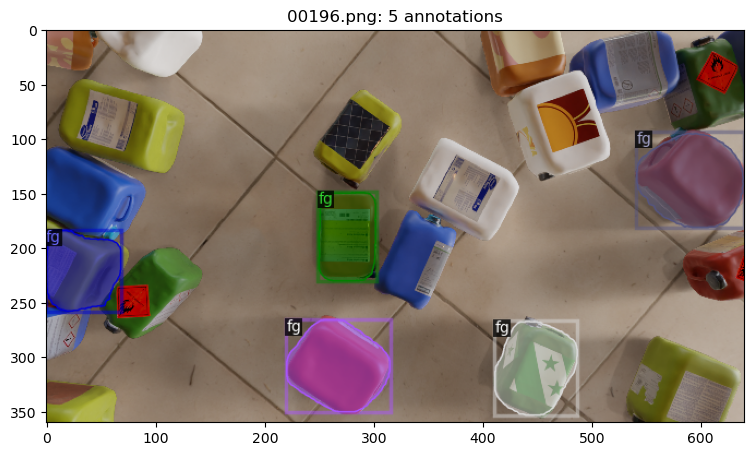

In [25]:
registerCatalog(rnd_name_te,p2nj_te,imgs_test)
visualizeSample(6,rnd_name_te)

## jerry_real

#### Path to datasets, annotations

In [2]:
# path to data/annotations in "system" format
syspath="/home/dkhatanassia/detectron2_dataset"

#*************************************** datasets *****************************************
dataset_train = 'jerry_sp10'
dataset_test = 'jerry_real'
DPI = 50
#******************************************************************************************

# root
root_train = join(syspath,dataset_train)
root_test = join(syspath,dataset_test)

# path to images{train, test}
imgs_train = join(root_train,'imgs')
imgs_test = join(root_test,'_imgs')

# path to json{train, test}
json_name_GT = f'GT_{dataset_test}.json'
json_name_GT_tr = f'tr_GT_{dataset_train}.json'
json_name_GT_te = f'te_GT_{dataset_test}.json'
json_name_mc = f'mc_{dataset_test}.json'
json_name_mc_tr = f'tr_mc_{dataset_train}.json'
json_name_mc_te = f'te_mc_{dataset_test}.json'

json_path_GT = join(root_test,'annotations',json_name_GT)
json_path_GT_tr = join(root_train,'annotations',json_name_GT_tr)
json_path_GT_te = join(root_test,'annotations',json_name_GT_te)
json_path_mc = join(root_test,'annotations',json_name_mc)
json_path_mc_tr = join(root_train,'annotations',json_name_mc_tr)
json_path_mc_te = join(root_test,'annotations',json_name_mc_te)

# builtin datasets location
%cd ~/CutLER/cutler
os.environ['DETECTRON2_DATASETS']='/home/dkhatanassia/CutLER/cutler/datasets'
print(os.getenv('DETECTRON2_DATASETS'))

/home/dkhatanassia/CutLER/cutler
/home/dkhatanassia/CutLER/cutler/datasets


#### Register datasets to detectron2

In [3]:
# register datasets
d2name = [
    json_name_GT,
    json_name_GT_tr,
    json_name_GT_te,
    json_name_mc,
    json_name_mc_tr,
    json_name_mc_te]

d2imgs = [
    imgs_test,
    imgs_train,
    imgs_test,
    imgs_test,
    imgs_train,
    imgs_test]

d2json = [
    json_path_GT,
    json_path_GT_tr,
    json_path_GT_te,
    json_path_mc,
    json_path_mc_tr,
    json_path_mc_te]

for key in range(len(d2name)):
    if not os.path.exists(d2json[key]): continue
    registerCatalog(d2name[key],d2json[key],d2imgs[key])

registered: GT_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/GT_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/_imgs

registered: tr_GT_jerry_sp10.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_sp10/annotations/tr_GT_jerry_sp10.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_sp10/imgs

registered: te_GT_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/te_GT_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/_imgs

registered: mc_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/mc_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/_imgs

registered: tr_mc_jerry_sp10.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_sp10/annotations/tr_mc_jerry_sp10.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_sp10/imgs

registered: te_mc_jerry_real.json
json 

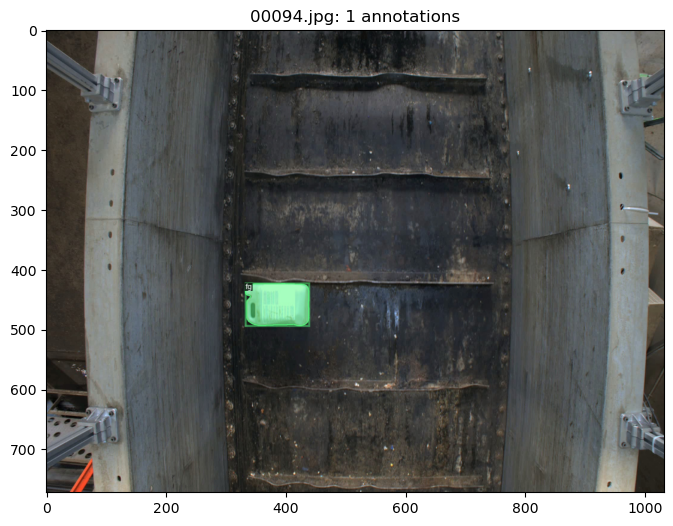

In [4]:
visualizeSample(15,json_name_GT_te)

#### Path to weights, outputs, ...

In [5]:
# current round
rnd = 'eval'

# path to output for current round
p2o = join(root_test,f'rd{rnd}')
if not os.path.exists(p2o):
    os.makedirs(p2o)
    print(f'created: {p2o}\n')
    
p2cfg = 'model_zoo/configs/CutLER-ImageNet/real_cascade_mask_rcnn_R_50_FPN.yaml'
p2w = '/home/dkhatanassia/CutLER/cutler/weights/jerry_sp10.pth'

#**** ANNOTATIONS *****
# path to new predictions
p2np =join(p2o,'inference/coco_instances_results.json')
# path to previous json
p2pj_tr = json_path_mc_tr
p2pj_te = json_path_mc_te

dict_path = {
    'config':p2cfg,
    'output':p2o,
    'new predictions':p2np,
    'prev json_tr':p2pj_tr,
    'prev json_te': p2pj_te}

print(f'ROUND: {rnd}')
[print(f'path to {d}: {dict_path[d].replace(root_train,".")}') for d in dict_path]


ROUND: eval
path to config: model_zoo/configs/CutLER-ImageNet/real_cascade_mask_rcnn_R_50_FPN.yaml
path to output: /home/dkhatanassia/detectron2_dataset/jerry_real/rdeval
path to new predictions: /home/dkhatanassia/detectron2_dataset/jerry_real/rdeval/inference/coco_instances_results.json
path to prev json_tr: ./annotations/tr_mc_jerry_sp10.json
path to prev json_te: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/te_mc_jerry_real.json


[None, None, None, None, None]

In [ ]:
%cd ~/CutLER/cutler
%run train_net.py --num-gpus 1 \
--config-file '{p2cfg}' \
--test-dataset '{json_name_GT_te}' \
--eval-only TEST.DETECTIONS_PER_IMAGE '{DPI}' \
OUTPUT_DIR '{p2o}'

In [41]:
df_bbox = init_df(p2o)
df_segm = init_df(p2o)
get_results(p2o, df_bbox, df_segm, 'eval')
df_bbox.to_csv(join(p2o,'bbox.csv'), index=False)
df_segm.to_csv(join(p2o,'segm.csv'), index=False)

In [42]:
df_bbox

,AP,AP50,AP75,APs,APm,APl,CP_nb
0,49.4249,73.8706,55.802,0,0.6144,53.9642,eval


In [43]:
df_segm

,AP,AP50,AP75,APs,APm,APl,CP_nb
1,52.3246,75.3052,61.2526,0,0.575,57.0426,eval


#### Test DPI and th

In [6]:
p2dpith = join(p2o,'DPI_th')

DPIs = [1,5,10,50]
ths = [0.01] + list(np.arange(0.5,1,0.05).round(2)) + [0.99]

##### generate jsons

In [ ]:
for dpi in DPIs:
    %cd ~/CutLER/cutler
    %run train_net.py --num-gpus 1 \
    --config-file model_zoo/configs/CutLER-ImageNet/sp10_cascade_mask_rcnn_R_50_FPN.yaml \
    --test-dataset '{json_name_mc_te}'\
    --eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}'\
    MODEL.WEIGHTS '{p2w}' \
    OUTPUT_DIR '{p2dpith}'
        
    for tmp_th in ths:
        tmp_pred = join(p2dpith,'inference','coco_instances_results.json')
        tmp_rnd_name = f'te_{dataset_test}_rd{rnd}_DPI{dpi}_th{tmp_th}.json'
        tmp_new = join(p2dpith,tmp_rnd_name)
    
        %cd ~/CutLER/cutler/tools
        %run get_self_training_ann.py \
        --new-pred '{tmp_pred}' \
        --prev-ann '{p2pj_te}'  \
        --save-path '{tmp_new}' \
        --threshold '{tmp_th}'

In [7]:
plotDPIthInfo(p2dpith,rnd,DPIs,ths,dataset_test,json_path_GT_te)

FileNotFoundError: [Errno 2] No such file or directory: '/home/dkhatanassia/detectron2_dataset/jerry_real/rdeval/DPI_th/te_jerry_real_rdeval_DPI1_th0.01.json'

#### Generate new predictions based on results, threshold them

In [21]:
dpi = 50
th = 0.95

rnd_name_te = f'te_{dataset_test}_rd{rnd}_DPI{dpi}_th{th}.json'
p2nj_te = join(p2o,rnd_name_te)

In [ ]:
# test - generate using dpi
%cd ~/CutLER/cutler
%run train_net.py --num-gpus 1 \
--config-file '{p2cfg}' \
--test-dataset '{json_name_GT_te}' \
--eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}' \
MODEL.WEIGHTS '{p2w}' \
OUTPUT_DIR '{p2o}'
# test - threshold
%cd ~/CutLER/cutler/tools
%run get_self_training_ann.py \
--new-pred '{p2np}' \
--prev-ann '{p2pj_te}'  \
--save-path '{p2nj_te}' \
--threshold '{th}'

#### Register new pseudoGT

registered: te_jerry_real_rdeval_DPI50_th0.95.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/rdeval/te_jerry_real_rdeval_DPI50_th0.95.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/_imgs

[05/25 11:47:51 d2.data.datasets.coco]: Loaded 50 images in COCO format from /home/dkhatanassia/detectron2_dataset/jerry_real/rdeval/te_jerry_real_rdeval_DPI50_th0.95.json
[05/25 11:47:51 d2.data.datasets.coco]: Loaded 50 images in COCO format from /home/dkhatanassia/detectron2_dataset/jerry_real/rdeval/te_jerry_real_rdeval_DPI50_th0.95.json


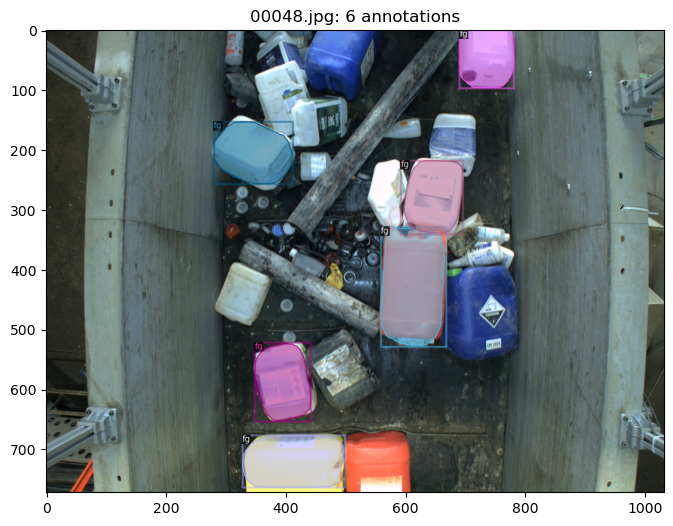

[05/25 11:47:52 d2.data.datasets.coco]: Loaded 50 images in COCO format from /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/te_GT_jerry_real.json
[05/25 11:47:52 d2.data.datasets.coco]: Loaded 50 images in COCO format from /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/te_GT_jerry_real.json


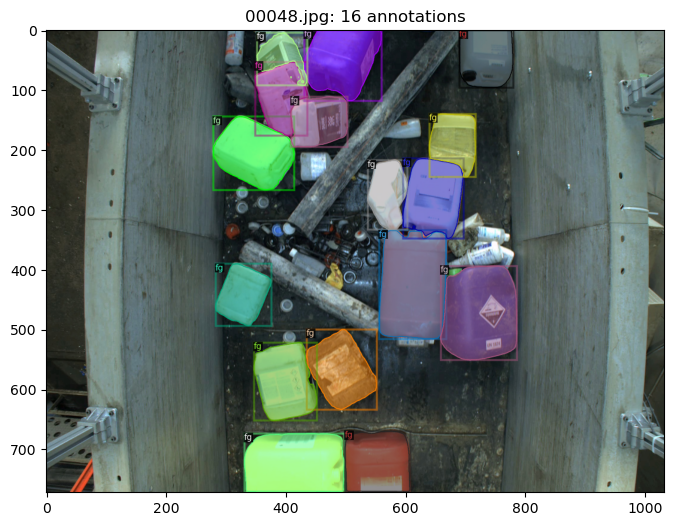

In [41]:
registerCatalog(rnd_name_te,p2nj_te,imgs_test)
sample = 10
visualizeSample(sample,rnd_name_te)
visualizeSample(sample,json_name_GT_te)

In [153]:
with open(json_path_GT, 'r') as f:
    lala= json.load(f)
    
#collect ids
ids = []
for d in lala['annotations']:
    ids.append(d['id'])
    
# find duplicates
checked = []
nonunique =[]
for d in ids:
    if d in checked: nonunique.append(d)
    checked.append(d)
    
delete = []
for d in nonunique:
    i = 0
    for j in ids:
        if j == d: i+=1
    delete.append(i-1)

nonunique, delete
        

([2182, 2248, 1836, 2067, 1335, 2096, 2097, 2098, 1321, 1528, 1960, 2013],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [159]:
for idx,i in enumerate(lala['annotations']):
    if i['id'] in nonunique:
        lala['annotations'].pop(idx)
        nonunique.remove(i['id'])
        
#collect ids
ids = []
for d in lala['annotations']:
    ids.append(d['id'])
# find duplicates
checked = []
nonunique =[]
for d in ids:
    if d in checked: nonunique.append(d)
    checked.append(d)
assert len(nonunique)==0, f'len is {len(nonunique)}'

with open(json_path_GT, 'w') as f:
    json.dump(lala, f)


## jerry_test

#### Path to datasets, annotations

In [196]:
# path to data/annotations in "system" format
syspath="/home/dkhatanassia/detectron2_dataset"

#*************************************** datasets *****************************************
dataset_train = 'jerry_sp10'
dataset_test = 'jerry_test'
DPI = 50
#******************************************************************************************

# root
root_train = join(syspath,dataset_train)
root_test = join(syspath,dataset_test)

# path to images{train, test}
imgs_train = join(root_train,'imgs')
imgs_test = join(root_test,'imgs')

imgs_mc_test = join(root_test,'imgs_mc')

# path to json{train, test}
json_name_GT = f'GT_{dataset_test}.json'
json_name_GT_tr = f'tr_GT_{dataset_train}.json'
json_name_GT_te = f'te_GT_{dataset_test}.json'
json_name_mc = f'mc_{dataset_test}.json'
json_name_mc_tr = f'tr_mc_{dataset_train}.json'
json_name_mc_te = f'te_mc_{dataset_test}.json'

json_path_GT = join(root_test,'annotations',json_name_GT)
json_path_GT_tr = join(root_train,'annotations',json_name_GT_tr)
json_path_GT_te = join(root_test,'annotations',json_name_GT_te)
json_path_mc = join(root_test,'annotations',json_name_mc)
json_path_mc_tr = join(root_train,'annotations',json_name_mc_tr)
json_path_mc_te = join(root_test,'annotations',json_name_mc_te)

# builtin datasets location
%cd ~/CutLER/cutler
os.environ['DETECTRON2_DATASETS']='/home/dkhatanassia/CutLER/cutler/datasets'
print(os.getenv('DETECTRON2_DATASETS'))

/home/dkhatanassia/CutLER/cutler
/home/dkhatanassia/CutLER/cutler/datasets


In [199]:
# register datasets
d2name = [
    json_name_GT,
    json_name_GT_tr,
    json_name_GT_te,
    json_name_mc,
    json_name_mc_tr,
    json_name_mc_te]

d2imgs = [
    imgs_test,
    imgs_train,
    imgs_test,
    imgs_test,
    imgs_train,
    imgs_test]

d2json = [
    json_path_GT,
    json_path_GT_tr,
    json_path_GT_te,
    json_path_mc,
    json_path_mc_tr,
    json_path_mc_te]

for key in range(len(d2name)):
    if not os.path.exists(d2json[key]): continue
    registerCatalog(d2name[key],d2json[key],d2imgs[key])

registered: tr_GT_jerry_sp10.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_sp10/annotations/tr_GT_jerry_sp10.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_sp10/imgs

registered: mc_jerry_test.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_test/annotations/mc_jerry_test.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_test/imgs

registered: tr_mc_jerry_sp10.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_sp10/annotations/tr_mc_jerry_sp10.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_sp10/imgs

registered: te_mc_jerry_test.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_test/annotations/te_mc_jerry_test.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_test/imgs



In [200]:
adaptMaskCutGT(json_path_mc,imgs_mc_test)

Search and replace operation completed successfully!


In [201]:
# current round
rnd = 'eval'

# path to output for current round
p2o = join(root_test,f'rd{rnd}')
if not os.path.exists(p2o):
    os.makedirs(p2o)
    print(f'created: {p2o}\n')
    
p2cfg = 'model_zoo/configs/CutLER-ImageNet/sp10_cascade_mask_rcnn_R_50_FPN.yaml'
p2w = '/home/dkhatanassia/CutLER/cutler/weights/jerry_sp10.pth'

#**** ANNOTATIONS *****
# path to new predictions
p2np =join(p2o,'inference/coco_instances_results.json')
# path to previous json
p2pj_tr = json_path_mc_tr
p2pj_te = json_path_mc_te

dict_path = {
    'config':p2cfg,
    'output':p2o,
    'new predictions':p2np,
    'prev json_tr':p2pj_tr,
    'prev json_te': p2pj_te}

print(f'ROUND: {rnd}')
[print(f'path to {d}: {dict_path[d].replace(root_train,".")}') for d in dict_path]


ROUND: eval
path to config: model_zoo/configs/CutLER-ImageNet/sp10_cascade_mask_rcnn_R_50_FPN.yaml
path to output: /home/dkhatanassia/detectron2_dataset/jerry_test/rdeval
path to new predictions: /home/dkhatanassia/detectron2_dataset/jerry_test/rdeval/inference/coco_instances_results.json
path to prev json_tr: ./annotations/tr_mc_jerry_sp10.json
path to prev json_te: /home/dkhatanassia/detectron2_dataset/jerry_test/annotations/te_mc_jerry_test.json


[None, None, None, None, None]

#### Generate new predictions based on results, threshold them

In [ ]:
dpi = 50
th = 0.8

rnd_name_te = f'te_{dataset_test}_rd{rnd}_DPI{dpi}_th{th}.json'
p2nj_te = join(p2o,rnd_name_te)

# test - generate using dpi
%cd ~/CutLER/cutler
%run train_net.py --num-gpus 1 \
--config-file model_zoo/configs/CutLER-ImageNet/sp10_cascade_mask_rcnn_R_50_FPN.yaml \
--test-dataset '{json_name_mc_te}' \
--eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}' \
MODEL.WEIGHTS '{p2w}' \
OUTPUT_DIR '{p2o}'
# test - threshold
%cd ~/CutLER/cutler/tools
%run get_self_training_ann.py \
--new-pred '{p2np}' \
--prev-ann '{p2pj_te}'  \
--save-path '{p2nj_te}' \
--threshold '{th}'

registered: te_jerry_test_rdeval_DPI50_th0.8.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_test/rdeval/te_jerry_test_rdeval_DPI50_th0.8.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_test/imgs

[05/17 21:13:41 d2.data.datasets.coco]: Loaded 18 images in COCO format from /home/dkhatanassia/detectron2_dataset/jerry_test/rdeval/te_jerry_test_rdeval_DPI50_th0.8.json
[05/17 21:13:41 d2.data.datasets.coco]: Loaded 18 images in COCO format from /home/dkhatanassia/detectron2_dataset/jerry_test/rdeval/te_jerry_test_rdeval_DPI50_th0.8.json


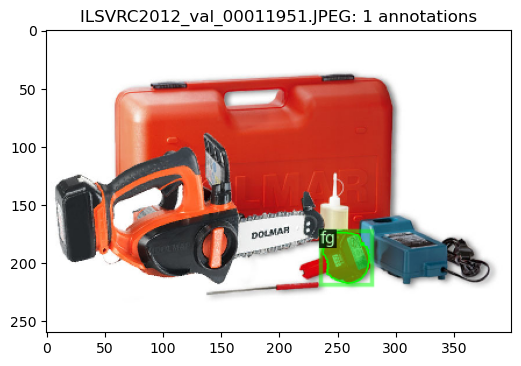

In [231]:
registerCatalog(rnd_name_te,p2nj_te,imgs_test)
visualizeSample(9,rnd_name_te)